<a href="https://colab.research.google.com/github/R-802/LING-226-Assignments/blob/main/Assignment_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Shemaiah Rangitaawa** `300601546`
Attempting Challenge

### **Text Preprocessing `preprocess_text`**
**Remove Punctuation**
- The function strips all punctuation from the text.

**Remove Stopwords**
- Stopwords, like "the", "is", "at" are removed from the text.

**Lowercase All Words**
- The text is converted to lowercase. This standardization is important as it prevents the same words in different cases from being counted as different words (e.g., "Hello" and "hello").

**Remove Words Above a Certain Frequency (Inclusive)**
- Words that appear very rarely or very frequently in the dataset can be removed. Rare words might be typos or irrelevant, and very common words might not carry useful information.


In [ ]:
import re
from collections import Counter

def preprocess_text(text, stopwords, removal_frequency):
    """
    Preprocesses the given text by removing punctuation, converting to lowercase,
    and then filtering out stopwords and words that exceed a specified frequency threshold.

    Args:
    text (str): The text to be preprocessed.
    stopwords (set): A set of words to be removed from the text.
    removal_frequency (int): A threshold frequency; words that appear more often than this will be removed.

    Returns:
    tuple: A tuple containing the processed text and a list of removed words.
    """
    # Lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text).lower()

    # Split text into words
    words = text.split()

    # Count the frequency of each word
    word_frequency = Counter(words)

    # Identify words to remove: stopwords and words exceeding the frequency threshold
    removed_words = set(stopwords).union(
        {word for word, freq in word_frequency.items() if freq >= removal_frequency}
    )

    # Filter out removed words
    processed_words = [word for word in words if word not in removed_words]

    return ' '.join(processed_words), list(removed_words)

### **Function to Reveal Removed Characters `print_removed`**

**Processes Original Text**
- Converts all characters to lowercase.
- Removes any characters that are not alphanumeric or whitespace.
- Splits the text into words.

**Process Preprocessed Text**
- Splits the preprocessed text into words.

**Compare Words**
- Uses word frequency counts to identify which words from the original text are not present in the preprocessed text.
- Generates a list of these removed words.

**Identify Removed Characters**
- Compares the character sets of the original and preprocessed texts.
- Lists characters present in the original text but not in the preprocessed text.

In [238]:
from typing import List, Tuple

def text_metrics(text: str) -> Tuple[int, float, float, int, List[Tuple[str, int]]]:
    # Tokenizing the text into words
    words = re.findall(r'\b\w+\b', text.lower())
    total_words = len(words)

    # Overall lexical diversity (unique words / total words)
    unique_words = len(set(words))
    overall_lexical_diversity = unique_words / total_words if total_words > 0 else 0

    # Tokenizing the text into sentences and calculating diversity
    sentences = re.split(r'[.!?]', text)
    num_sentences = len(sentences)  # Number of sentences in the text
    sentence_diversities = []
    for sentence in sentences:
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        unique_in_sentence = len(set(sentence_words))
        total_in_sentence = len(sentence_words)
        if total_in_sentence > 0:
            sentence_diversities.append(unique_in_sentence / total_in_sentence)

    # Average lexical diversity of text sentences
    avg_sentence_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    word_frequencies = Counter(words)
    top_ten_words = word_frequencies.most_common(10)

    return total_words, overall_lexical_diversity, avg_sentence_diversity, num_sentences, top_ten_words

### **Text Metric Function `text_metrics`**
**Total Words**
- The total count of words in the text.

**Overall Lexical Diversity**
- The ratio of unique words to the total number of words, providing a measure of the text's vocabulary variety.

**Average Sentence Lexical Diversity**
- The average diversity of vocabulary used across all sentences in the text.

**Top Ten Most Frequent Word:**
- A list of the ten most commonly used words in the text, along with their frequencies.

In [241]:
def text_metrics(text):
    # Tokenizing the text into words
    words = re.findall(r'\b\w+\b', text.lower())
    total_words = len(words)

    # Overall lexical diversity (unique words / total words)
    unique_words = len(set(words))
    overall_lexical_diversity = unique_words / total_words if total_words > 0 else 0

    # Tokenizing the text into sentences and calculating diversity
    sentences = re.split(r'[.!?]', text)
    sentence_diversities = []
    for sentence in sentences:
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        unique_in_sentence = len(set(sentence_words))
        total_in_sentence = len(sentence_words)
        if total_in_sentence > 0:
            sentence_diversities.append(unique_in_sentence / total_in_sentence)

    # Average lexical diversity of text sentences
    avg_sentence_lexical_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    word_frequencies = Counter(words)
    top_ten_words = word_frequencies.most_common(10)

    # Number of sentences
    num_sentences = len(sentences)

    return total_words, overall_lexical_diversity, avg_sentence_lexical_diversity, top_ten_words, num_sentences


###**Formatting for Text Metrics**

In [246]:
def format_metrics(title, metrics):
    formatted_top_words = ', '.join([word for word, _ in metrics[3]])
    highest_word, highest_freq = metrics[3][0]  # Extracting the highest frequency word and its frequency

    # Formatting the diversities as percentages
    overall_diversity_percentage = metrics[1] * 100
    avg_sentence_diversity_percentage = metrics[2] * 100

    return (f"--------- Text Metrics for {title} ---------\n"
            f"Total Words: {metrics[0]}\n"
            f"Total Sentences: {metrics[4]}\n"
            f"Overall Lexical Diversity: {overall_diversity_percentage:.2f}%\n"
            f"Average Lexical Diversity of Sentences: {avg_sentence_diversity_percentage:.2f}%\n"
            f"Top Ten Most Frequent Words: {formatted_top_words}\n"
            f"Highest Frequency Word: '{highest_word}' (Frequency: {highest_freq})")


## **Importing and Reading `TP001.txt` from URL and `austen-emma.txt` from NLTK corpora**

In [ ]:
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt'

--2023-11-16 05:24:12--  https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220746 (216K) [text/plain]
Saving to: ‘tp001.txt’

tp001.txt           100%[===================>] 215.57K  --.-KB/s    in 0.02s   

2023-11-16 05:24:13 (11.5 MB/s) - ‘tp001.txt’ saved [220746/220746]



In [ ]:
# Open the file and read its lines
with open('tp001.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Concatenate all comments into a single text string
tp001_text = ""
for line in lines:
    if '\t' in line:
        comment = line.split('\t')[1].strip()  # Extract and strip the comment
        tp001_text += comment + " "  # Add the comment to the text string

# Optionally, display the first part of the concatenated text
print("First part of tp001_text:", tp001_text[:500])

First part of tp001_text: ... we need to work hard to make it happen 3d is better than other bands in the whole country a ban on sales of new petrol vehicles would be more sensible than an outright ban .  an outright ban is itself wasteful A carless life is much more fun A good idea in theory but would have to change a lot of infrastructure. Not to mention industry and jobs. a good idea to protect our earth ! A good opportunity to reduce harm to the environment A N G E R Y A s part of many other changes A STEP IN THE RIG


In [170]:
import nltk
from nltk.corpus import gutenberg

# Download gutenberg corpus
nltk.download('gutenberg')

# Using Emma by Jane Austen 1816
emma_text = gutenberg.raw('austen-emma.txt')
print(emma_text[:290])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.



[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


# **Experimentation**
The following experimentation section includes:
- Visualization of the top ten words before and after processing.

**Notes:** I have chosen to use the NLTK's stopword list for preprocessing. I  have used 'Emma by Jane Austen 1816' from NLTK corpora and 'TP001 (Petrol cars should be banned by 2030)' from The Current.

### **Importing libraries and initializing stopwords set**
Required for preprocessing and visualization.

In [171]:
import random
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

# Tokenizer divides a text into a list of sentences
nltk.download('punkt')

# Download the stopwords from NLTK
nltk.download('stopwords')

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# For some reason 'n' was the top word in tp001
stop_words.add('n')

print(stop_words)

{'been', 'than', 'him', 'over', 'each', 'there', "couldn't", 'n', 'did', 'he', 'no', 'both', 'of', 'own', 'about', 'between', 'now', 'hasn', 'below', 'didn', 'd', 'ain', 'any', 'it', 'them', 'yours', 'then', 'most', 'my', "you'll", 'too', "won't", "isn't", "wouldn't", "hadn't", 'couldn', 'haven', 'because', 'they', 'be', 'who', 'from', "should've", "shouldn't", 'herself', 'this', 'that', 'had', 'do', 'not', 'yourselves', 'mustn', 'its', 'is', 'themselves', 'are', 'an', "hasn't", 'theirs', 'out', 'all', 'don', 'mightn', 'her', "needn't", 'was', 'shan', 'in', "you've", 'other', 'through', 'some', 'we', 'hadn', 's', 'll', 'doing', 've', "weren't", 'has', 're', "you're", "didn't", 'am', 'but', 'so', 'what', "don't", 'wasn', 'more', 'just', "you'd", 'few', 'why', "haven't", 'isn', 'shouldn', 'where', 'hers', 'have', 'off', 'she', 'itself', 'up', 'ma', 'further', "aren't", 'down', 'above', "it's", 'nor', 'wouldn', "that'll", 'and', 'i', 'again', 'such', 'with', "shan't", 'until', 'same', 'wh

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Initalizing text metrics for comparison of texts before and after preprocessing**
Here we gather the data for comparison and analysis.

In [248]:
# Get text metrics for raw unprocessed text
emma_metrics = text_metrics(emma_text)
tp001_metrics = text_metrics(tp001_text)

# Extracting top ten words and their frequencies for plotting for both texts
emma_top_ten_words, emma_frequencies = zip(*emma_metrics[3])
tp001_top_ten_words, tp001_frequencies = zip(*tp001_metrics[3])

# Extract the number of sentences
emma_num_sentences = emma_metrics[4]
tp001_num_sentences = tp001_metrics[4]

# Generate a random text occurrence removal frequency
random_frequency = random.randint(125, 300)

# Preprocess the texts
preprocessed_emma, _ = preprocess_text(emma_text, stop_words, random_frequency)
preprocessed_tp001, _ = preprocess_text(tp001_text, stop_words, random_frequency)

# Get metrics for preprocessed texts
preprocessed_emma_metrics = text_metrics(preprocessed_emma)
preprocessed_tp001_metrics = text_metrics(preprocessed_tp001)

# Extracting top ten words and their frequencies for preprocessed texts
preprocessed_emma_top_ten, preprocessed_emma_freq = zip(*preprocessed_emma_metrics[3])
preprocessed_tp001_top_ten, preprocessed_tp001_freq = zip(*preprocessed_tp001_metrics[3])

# Extract the number of sentences for preprocessed texts
preprocessed_emma_num_sentences = preprocessed_emma_metrics[4]
preprocessed_tp001_num_sentences = preprocessed_tp001_metrics[4]

print(format_metrics("Emma (Unprocessed)", emma_metrics) + "\n")
print(format_metrics("tp001.txt (Unprocessed)", tp001_metrics) + "\n")
print(format_metrics("Emma (Processed)", preprocessed_emma_metrics) + "\n")
print(format_metrics("tp001.txt (Processed)", preprocessed_tp001_metrics) + "\n")
print(f"\nRemoved words that occurred more than {random_frequency} times.")

--------- Text Metrics for Emma (Unprocessed) ---------
Total Words: 161983
Total Sentences: 10567
Overall Lexical Diversity: 4.48%
Average Lexical Diversity of Sentences: 94.43%
Top Ten Most Frequent Words: to, the, and, of, i, a, it, her, was, she
Highest Frequency Word: 'to' (Frequency: 5239)

--------- Text Metrics for tp001.txt (Unprocessed) ---------
Total Words: 39065
Total Sentences: 2037
Overall Lexical Diversity: 12.06%
Average Lexical Diversity of Sentences: 89.43%
Top Ten Most Frequent Words: the, to, we, and, i, it, a, is, be, for
Highest Frequency Word: 'the' (Frequency: 1507)

--------- Text Metrics for Emma (Processed) ---------
Total Words: 56717
Total Sentences: 1
Overall Lexical Diversity: 16.38%
Average Lexical Diversity of Sentences: 16.38%
Top Ten Most Frequent Words: ever, young, churchill, two, though, indeed, better, come, oh, body
Highest Frequency Word: 'ever' (Frequency: 191)

--------- Text Metrics for tp001.txt (Processed) ---------
Total Words: 18059
Tota

### **Visualization of The Top Ten Words with Their Frequencies**

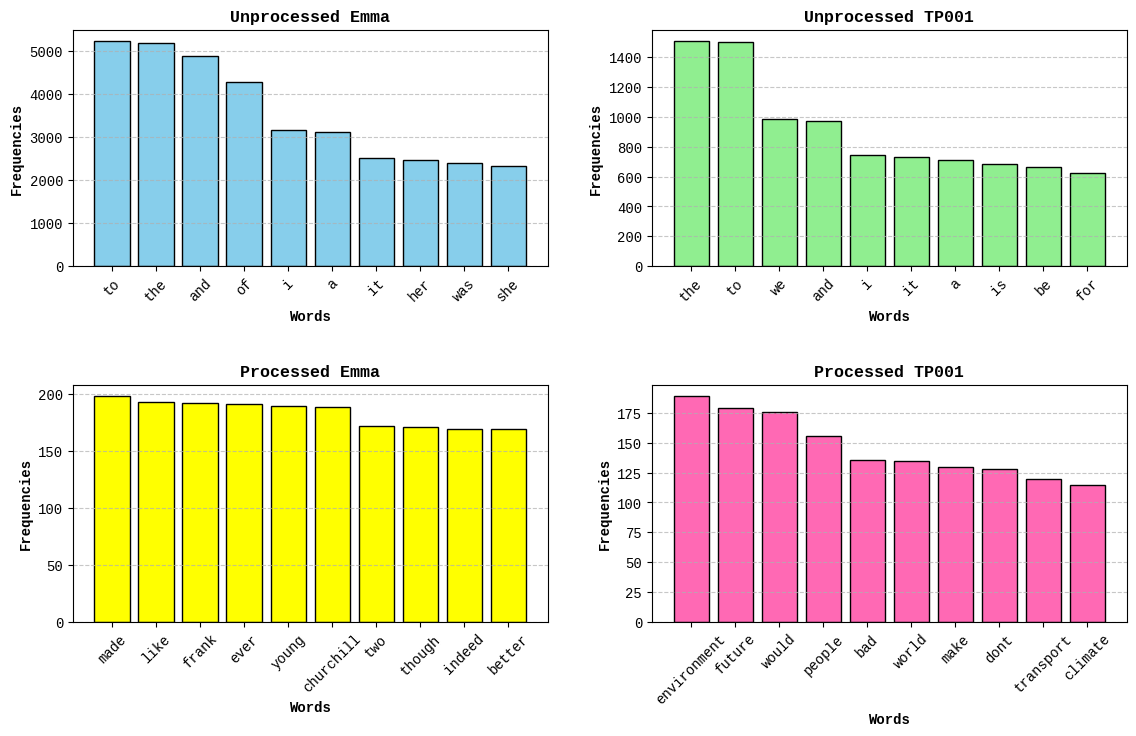


Removed words that occur more than 199 times.


In [231]:
# Plotting the graphs for both original and preprocessed texts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
bold_font = FontProperties(family='Liberation Mono', weight='bold', size=12)
small_bold_font = FontProperties(family='Liberation Mono', weight='bold', size=10)
label_font = FontProperties(family='Liberation Mono', size=10)

# Original Emma
axes[0, 0].bar(emma_top_ten_words, emma_frequencies, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Unprocessed Emma', fontproperties=bold_font)
axes[0, 0].set_xlabel('Words', fontproperties=small_bold_font)
axes[0, 0].set_ylabel('Frequencies', fontproperties=small_bold_font)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[0, 0].get_xticklabels() + axes[0, 0].get_yticklabels():
    label.set_fontproperties(label_font)

# Original TP001
axes[0, 1].bar(tp001_top_ten_words, tp001_frequencies, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Unprocessed TP001', fontproperties=bold_font)
axes[0, 1].set_xlabel('Words', fontproperties=small_bold_font)
axes[0, 1].set_ylabel('Frequencies', fontproperties=small_bold_font)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[0, 1].get_xticklabels() + axes[0, 1].get_yticklabels():
    label.set_fontproperties(label_font)

# Preprocessed Emma
axes[1, 0].bar(preprocessed_emma_top_ten, preprocessed_emma_freq, color='yellow', edgecolor='black')
axes[1, 0].set_title('Processed Emma', fontproperties=bold_font)
axes[1, 0].set_xlabel('Words', fontproperties=small_bold_font)
axes[1, 0].set_ylabel('Frequencies', fontproperties=small_bold_font)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[1, 0].get_xticklabels() + axes[1, 0].get_yticklabels():
    label.set_fontproperties(label_font)

# Preprocessed TP001
axes[1, 1].bar(preprocessed_tp001_top_ten, preprocessed_tp001_freq, color='hotpink', edgecolor='black')
axes[1, 1].set_title('Processed TP001', fontproperties=bold_font)
axes[1, 1].set_xlabel('Words', fontproperties=small_bold_font)
axes[1, 1].set_ylabel('Frequencies', fontproperties=small_bold_font)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[1, 1].get_xticklabels() + axes[1, 1].get_yticklabels():
    label.set_fontproperties(label_font)

# Show the plots
plt.tight_layout(pad=3)
plt.show()
print(f"\nRemoved words that occur more than {random_frequency} times.")

In [240]:
batch_sizes = list(range(20, 501, 20))  # Incrementally increase batch size
overall_lex_div_processed = []
avg_sentence_lex_div_processed = []

for batch_size in batch_sizes:
    # Split the text into sentences for the current batch size
    sentences = sent_tokenize(emma_text)
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    emma_ldv_processed = []
    avg_sentence_ldv_processed = []

    for batch in batches:
        batch_text = ' '.join(batch)

        # Using text_metrics for unprocessed batch
        _, overall_lex_div_unprocessed, avg_sentence_lex_div_unprocessed, _ , _ = text_metrics(batch_text)

        # Process batch and use text_metrics for processed text
        processed_text, _ = preprocess_text(batch_text, stop_words, random_frequency)
        _, overall_lex_div_processed, avg_sentence_lex_div_processed, _ , _ = text_metrics(processed_text)

    overall_lex_div_processed.append(overall_lex_div_processed)
    avg_sentence_lex_div_processed.append(avg_sentence_lex_div_processed)

# Prepare batch size labels
batch_size_labels = [str(batch_size) for batch_size in batch_sizes]

# Plotting the graph
plt.figure(figsize=(12, 8))
plt.plot(batch_size_labels, overall_lex_div_processed, marker='o', linestyle='-', color='skyblue', label='Overall Lexical Diversity (Processed)')
plt.plot(batch_size_labels, avg_sentence_lex_div_processed, marker='o', linestyle='-', color='lightgreen', label='Avg. Sentence Lexical Diversity (Processed)')
plt.title('Lexical Diversity Analysis as Batch Size Increases', fontsize=16, fontweight='bold', fontfamily='Liberation Mono')
plt.xlabel('Batch Size (Number of Sentences)', fontsize=12, fontfamily='Liberation Mono')
plt.ylabel('Lexical Diversity', fontsize=12, fontfamily='Liberation Mono')
plt.legend()
plt.tick_params(axis='x', rotation=45, labelsize=10)
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

AttributeError: ignored